In [1]:
import numpy as np
import json, random
import matplotlib.pyplot as plt
from pathlib import Path
import importlib

SEED = 42
random.seed(SEED); np.random.seed(SEED)

try:
    import torch
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
except Exception:
    torch = None

In [2]:
from pyspectral.dataset import SpectraPair, Annotations
from pyspectral.features import ( PreConfig, _poly_baseline_subtract, _median_spike_removal, 
SmoothCfg, CubeStats, PreprocStats, PeakNormConfig, PeakNormMode, GuidedPeakNorm, _use_peak_norm, _normalize_to_peak)
from pyspectral.config import DATA_DIR, Cube, FlatMap
from itertools import product
from scipy.signal import savgol_filter

DATA = DATA_DIR
ANN  = DATA / "annotations_S80.csv"
H, W = 8, 8

# measure the effect pre-processing settings have
spike_k_low = 7
spike_k_none = None
spikes = [spike_k_low, spike_k_none]

base_poly_low = 2
base_poly_none = None
base_polys = [base_poly_low, base_poly_none]

#s_poly_high = 9
s_poly_low = 3
s_poly_none = None


#s_window_high = 30
s_window_low = 30
s_window_none = None
s_windows = [(s_poly_low, s_window_low), (s_window_none, s_poly_none)]

#settings = list(spike_k_low, base_poly_low, (s_poly_low, s_window_low))
settings = list(product(spikes, base_polys, s_windows))
#settings = list(product(spikes, base_polys, s_polys, s_windows))

def manual_pre_processing(cube_maybe, smooth, wl_cm1, spike, b_poly, peak_cfg: PeakNormConfig):
    cube = cube_maybe if isinstance(cube_maybe, Cube) else cube_maybe.cube
    y = cube.flatten()  # (N, M)
    # manual pre-processing ------------------------------------------------
    if spike is not None:
        # remove spikes
        y = _median_spike_removal(y, spike)
    if b_poly is not None:
        # find & remove baseline
        y = _poly_baseline_subtract(y, wl_cm1, degree=b_poly)
    if smooth is not None:

        # smoothing
        y = savgol_filter(y, window_length=smooth.window, polyorder=smooth.poly, axis=1).astype(np.float32)

    # normalization to peak
    ref_center = None
    ref_halfw = None
    stats = None
    if _use_peak_norm(peak_cfg):

        if isinstance(cube_maybe, Cube):
            stats = peak_cfg.fit_preproc(y, wl_cm1)
            ref_center = stats.get_center()
            ref_halfw = peak_cfg.halfwidth_cm1
        elif (
            isinstance(cube_maybe, CubeStats)
            and (c := cube_maybe.stats.ref_center_cm1) is not None
        ):
            # use the stats provided
            ref_center = c
            ref_halfw = cube_maybe.stats.ref_halfwidth_cm1 or peak_cfg.halfwidth_cm1
        else:
            raise RuntimeError(f"Invalid cube and stats combination {cube=}, {stats=}")
        if isinstance(y, FlatMap):
            y=y.get() # prevents cases where spike, poly, and smooth are all None, being normalized
        else:
            y = _normalize_to_peak(y, wl_cm1, ref_center, ref_halfw)

    # compute stats for testing set
    stats = stats if stats is not None else PreprocStats(ref_center, ref_halfw)

        
    if isinstance(y, FlatMap):
        return Cube.from_flat(y.get(), cube.H, cube.W, cube.M), stats
    return Cube.make(y.reshape(cube.H, cube.W, cube.M)), stats


def compare_data_pre_processing(spike_val, base_poly, s_poly, s_window):
    values = Annotations.read(ANN, DATA)
    x_list, y_list = [], []
    peak = PeakNormConfig(        mode=GuidedPeakNorm(window_cm1=(1000.0, 1150.0))
        # mode=FixedPeakNorm( center_cm1=1004.0))
                         )
    smooth = SmoothCfg(s_poly, s_window) if s_poly and s_window else None
    for r in values.rows:
        raw_map, prc_map = r.retrieve_maps()
        cube_x, cube_y, common_wl = raw_map.check_same_wavelength_grid(prc_map, None)
        cube_x, t_stats = manual_pre_processing(cube_x, smooth, common_wl, spike_val, base_poly, peak)
        cube_y, _ = manual_pre_processing(CubeStats(cube_y, t_stats), smooth, common_wl, spike_val, base_poly, peak)

        xpix = cube_x.get().reshape(-1, cube_x.M).astype(np.float64)
        ypix = cube_y.get().reshape(-1, cube_x.M).astype(np.float64)
        x_list.append(xpix)
        y_list.append(ypix)



    x_all = np.vstack(x_list, dtype=np.float64)
    y_all = np.vstack(y_list, dtype=np.float64)

    N, C = x_all.shape
    
    plt.plot(x_all.mean(0), label="Raw mean"); plt.plot(y_all.mean(0), label="LabSpec mean");
    plt.legend(); plt.title(f"Mean spectra {spike_val=}, {base_poly=}, {s_poly=}, {s_window=}"); plt.show()

_normalize_to_peak halfwidth: 12.0
_normalize_to_peak center: 1092.8187872611202
_normalize_to_peak wl: [ 501.18   502.963  504.745  506.525  508.307  510.086  511.867  513.646
  515.424  517.202  518.982  520.759  522.536  524.312  526.088  527.864
  529.64   531.415  533.19   534.962  536.736  538.51   540.281  542.055
  543.825  545.598  547.368  549.139  550.909  552.678  554.446  556.217
  557.985  559.752  561.52   563.287  565.053  566.817  568.583  570.349
  572.114  573.877  575.642  577.406  579.168  580.931  582.692  584.453
  586.216  587.976  589.735  591.495  593.254  595.013  596.771  598.529
  600.287  602.045  603.802  605.556  607.313  609.069  610.822  612.578
  614.331  616.086  617.838  619.59   621.344  623.095  624.846  626.597
  628.347  630.097  631.847  633.596  635.345  637.094  638.84   640.588
  642.335  644.081  645.828  647.572  649.318  651.062  652.806  654.551
  656.294  658.037  659.779  661.521  663.263  665.004  666.745  668.485
  670.226  671.964  

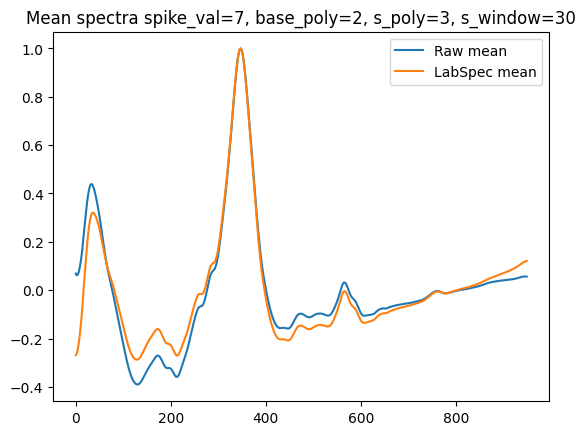

_normalize_to_peak halfwidth: 12.0
_normalize_to_peak center: 1093.3257596050996
_normalize_to_peak wl: [ 501.18   502.963  504.745  506.525  508.307  510.086  511.867  513.646
  515.424  517.202  518.982  520.759  522.536  524.312  526.088  527.864
  529.64   531.415  533.19   534.962  536.736  538.51   540.281  542.055
  543.825  545.598  547.368  549.139  550.909  552.678  554.446  556.217
  557.985  559.752  561.52   563.287  565.053  566.817  568.583  570.349
  572.114  573.877  575.642  577.406  579.168  580.931  582.692  584.453
  586.216  587.976  589.735  591.495  593.254  595.013  596.771  598.529
  600.287  602.045  603.802  605.556  607.313  609.069  610.822  612.578
  614.331  616.086  617.838  619.59   621.344  623.095  624.846  626.597
  628.347  630.097  631.847  633.596  635.345  637.094  638.84   640.588
  642.335  644.081  645.828  647.572  649.318  651.062  652.806  654.551
  656.294  658.037  659.779  661.521  663.263  665.004  666.745  668.485
  670.226  671.964  

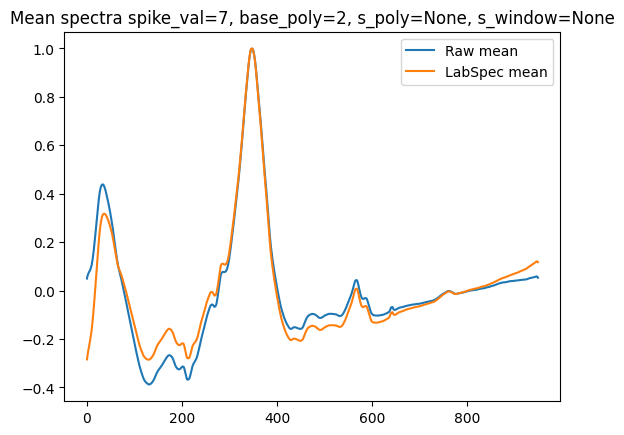

_normalize_to_peak halfwidth: 12.0
_normalize_to_peak center: 1092.8451145133772
_normalize_to_peak wl: [ 501.18   502.963  504.745  506.525  508.307  510.086  511.867  513.646
  515.424  517.202  518.982  520.759  522.536  524.312  526.088  527.864
  529.64   531.415  533.19   534.962  536.736  538.51   540.281  542.055
  543.825  545.598  547.368  549.139  550.909  552.678  554.446  556.217
  557.985  559.752  561.52   563.287  565.053  566.817  568.583  570.349
  572.114  573.877  575.642  577.406  579.168  580.931  582.692  584.453
  586.216  587.976  589.735  591.495  593.254  595.013  596.771  598.529
  600.287  602.045  603.802  605.556  607.313  609.069  610.822  612.578
  614.331  616.086  617.838  619.59   621.344  623.095  624.846  626.597
  628.347  630.097  631.847  633.596  635.345  637.094  638.84   640.588
  642.335  644.081  645.828  647.572  649.318  651.062  652.806  654.551
  656.294  658.037  659.779  661.521  663.263  665.004  666.745  668.485
  670.226  671.964  

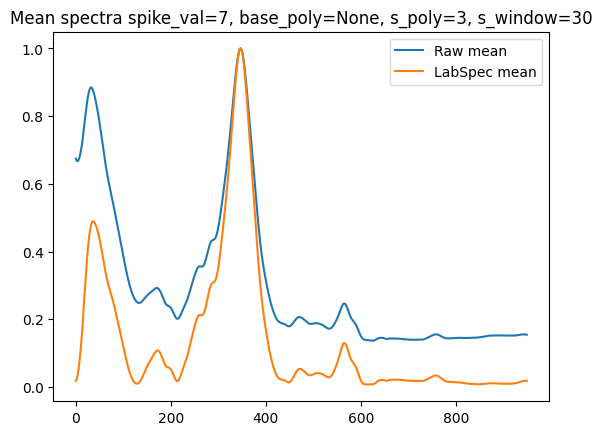

_normalize_to_peak halfwidth: 12.0
_normalize_to_peak center: 1092.0584979875405
_normalize_to_peak wl: [ 501.18   502.963  504.745  506.525  508.307  510.086  511.867  513.646
  515.424  517.202  518.982  520.759  522.536  524.312  526.088  527.864
  529.64   531.415  533.19   534.962  536.736  538.51   540.281  542.055
  543.825  545.598  547.368  549.139  550.909  552.678  554.446  556.217
  557.985  559.752  561.52   563.287  565.053  566.817  568.583  570.349
  572.114  573.877  575.642  577.406  579.168  580.931  582.692  584.453
  586.216  587.976  589.735  591.495  593.254  595.013  596.771  598.529
  600.287  602.045  603.802  605.556  607.313  609.069  610.822  612.578
  614.331  616.086  617.838  619.59   621.344  623.095  624.846  626.597
  628.347  630.097  631.847  633.596  635.345  637.094  638.84   640.588
  642.335  644.081  645.828  647.572  649.318  651.062  652.806  654.551
  656.294  658.037  659.779  661.521  663.263  665.004  666.745  668.485
  670.226  671.964  

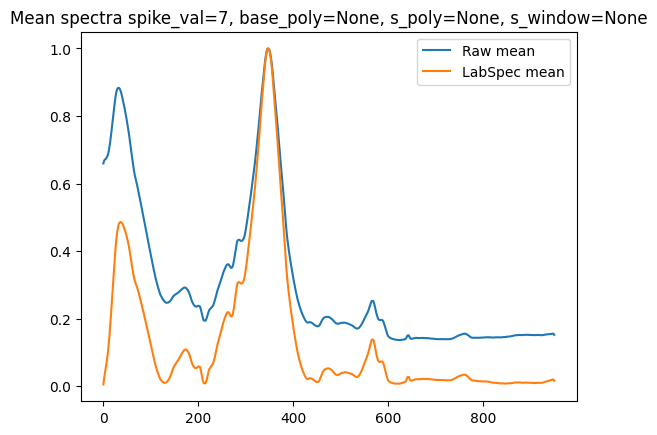

_normalize_to_peak halfwidth: 12.0
_normalize_to_peak center: 1092.8030603592765
_normalize_to_peak wl: [ 501.18   502.963  504.745  506.525  508.307  510.086  511.867  513.646
  515.424  517.202  518.982  520.759  522.536  524.312  526.088  527.864
  529.64   531.415  533.19   534.962  536.736  538.51   540.281  542.055
  543.825  545.598  547.368  549.139  550.909  552.678  554.446  556.217
  557.985  559.752  561.52   563.287  565.053  566.817  568.583  570.349
  572.114  573.877  575.642  577.406  579.168  580.931  582.692  584.453
  586.216  587.976  589.735  591.495  593.254  595.013  596.771  598.529
  600.287  602.045  603.802  605.556  607.313  609.069  610.822  612.578
  614.331  616.086  617.838  619.59   621.344  623.095  624.846  626.597
  628.347  630.097  631.847  633.596  635.345  637.094  638.84   640.588
  642.335  644.081  645.828  647.572  649.318  651.062  652.806  654.551
  656.294  658.037  659.779  661.521  663.263  665.004  666.745  668.485
  670.226  671.964  

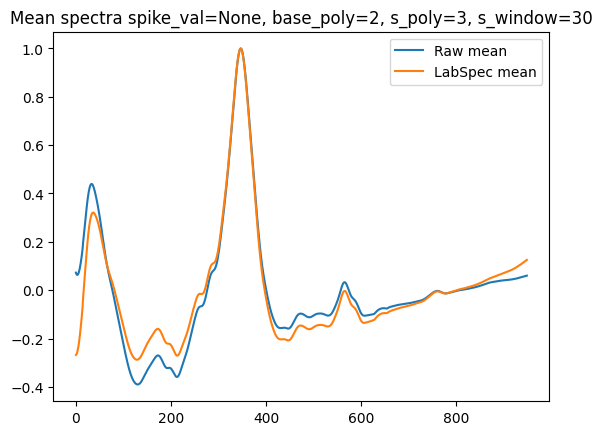

_normalize_to_peak halfwidth: 12.0
_normalize_to_peak center: 1092.4806552930875
_normalize_to_peak wl: [ 501.18   502.963  504.745  506.525  508.307  510.086  511.867  513.646
  515.424  517.202  518.982  520.759  522.536  524.312  526.088  527.864
  529.64   531.415  533.19   534.962  536.736  538.51   540.281  542.055
  543.825  545.598  547.368  549.139  550.909  552.678  554.446  556.217
  557.985  559.752  561.52   563.287  565.053  566.817  568.583  570.349
  572.114  573.877  575.642  577.406  579.168  580.931  582.692  584.453
  586.216  587.976  589.735  591.495  593.254  595.013  596.771  598.529
  600.287  602.045  603.802  605.556  607.313  609.069  610.822  612.578
  614.331  616.086  617.838  619.59   621.344  623.095  624.846  626.597
  628.347  630.097  631.847  633.596  635.345  637.094  638.84   640.588
  642.335  644.081  645.828  647.572  649.318  651.062  652.806  654.551
  656.294  658.037  659.779  661.521  663.263  665.004  666.745  668.485
  670.226  671.964  

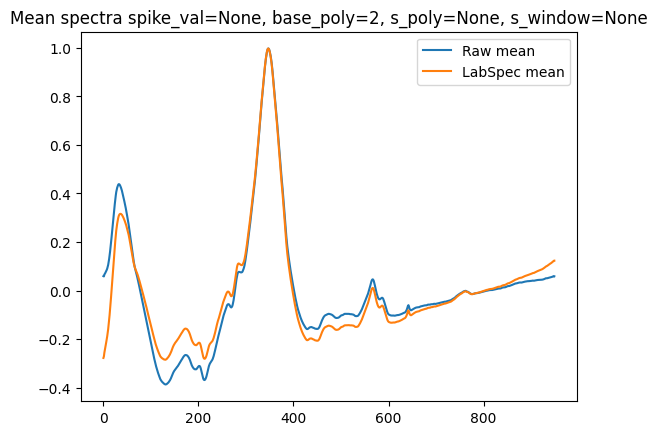

_normalize_to_peak halfwidth: 12.0
_normalize_to_peak center: 1092.8428567024882
_normalize_to_peak wl: [ 501.18   502.963  504.745  506.525  508.307  510.086  511.867  513.646
  515.424  517.202  518.982  520.759  522.536  524.312  526.088  527.864
  529.64   531.415  533.19   534.962  536.736  538.51   540.281  542.055
  543.825  545.598  547.368  549.139  550.909  552.678  554.446  556.217
  557.985  559.752  561.52   563.287  565.053  566.817  568.583  570.349
  572.114  573.877  575.642  577.406  579.168  580.931  582.692  584.453
  586.216  587.976  589.735  591.495  593.254  595.013  596.771  598.529
  600.287  602.045  603.802  605.556  607.313  609.069  610.822  612.578
  614.331  616.086  617.838  619.59   621.344  623.095  624.846  626.597
  628.347  630.097  631.847  633.596  635.345  637.094  638.84   640.588
  642.335  644.081  645.828  647.572  649.318  651.062  652.806  654.551
  656.294  658.037  659.779  661.521  663.263  665.004  666.745  668.485
  670.226  671.964  

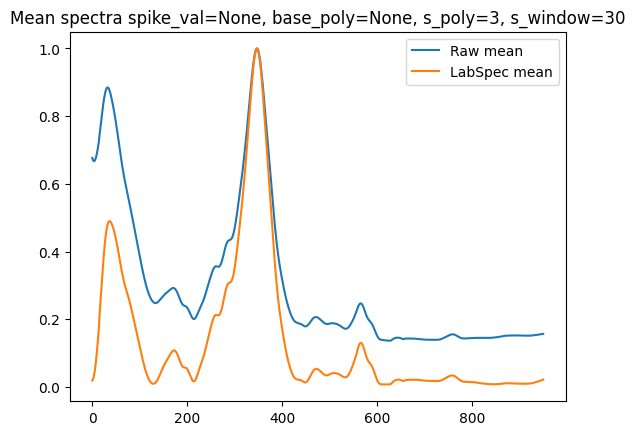

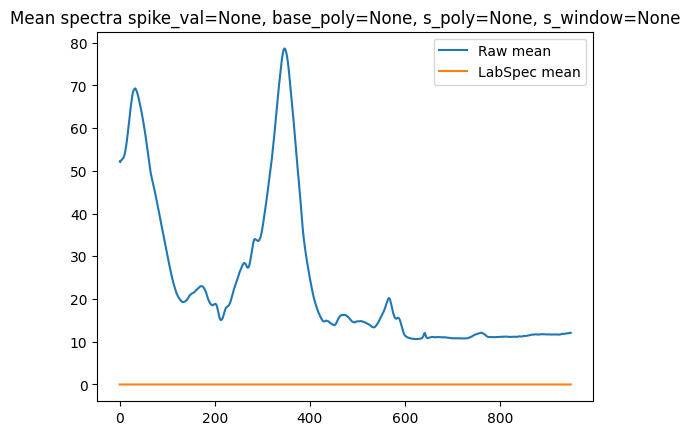

In [3]:
for spike, base, smooth in settings:
    s_window, s_poly = smooth
    try:
        compare_data_pre_processing(spike, base, s_window, s_poly )
    except Exception as e:
        print(e)